<a href="https://colab.research.google.com/github/cyyeh/sound-classification-project/blob/master/v2/sound_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sound Classification using UrbanSound8k Dataset

## Import dependencies

In [1]:
!pip install comet_ml

In [2]:
# import comet for experiment tracking and visual tools
from comet_ml import Experiment
from comet_ml import Optimizer

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from scipy.io import wavfile as wav
from pprint import pprint
import os

from tensorflow import keras

## Setup Comet

In [3]:
COMET_API_KEY = 'LevX0FaEuIea9vfmA61jUKKAZ'
COMET_PROJECT_NAME = 'sound-classification'
COMET_WORKSPACE = 'cyyeh'

In [4]:
experiment = Experiment(api_key=COMET_API_KEY,
                        project_name=COMET_PROJECT_NAME, workspace=COMET_WORKSPACE)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/cyyeh/sound-classification/3ba0eb22c9f14aa2a0cb66b6edb3eca2



## Download Dataset

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "chihyuyeh"
os.environ['KAGGLE_KEY'] = "b2baa785f3a1e4bfd9d77c8431f632c5"

In [6]:
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.61G/5.61G [02:37<00:00, 17.5MB/s]
100% 5.61G/5.61G [02:38<00:00, 38.1MB/s]


In [7]:
!unzip urbansound8k.zip -d urbansound8k
!rm urbansound8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: urbansound8k/fold4/154758-5-0-0.wav  
  inflating: urbansound8k/fold4/154758-5-0-1.wav  
  inflating: urbansound8k/fold4/154758-5-0-10.wav  
  inflating: urbansound8k/fold4/154758-5-0-11.wav  
  inflating: urbansound8k/fold4/154758-5-0-12.wav  
  inflating: urbansound8k/fold4/154758-5-0-13.wav  
  inflating: urbansound8k/fold4/154758-5-0-14.wav  
  inflating: urbansound8k/fold4/154758-5-0-15.wav  
  inflating: urbansound8k/fold4/154758-5-0-16.wav  
  inflating: urbansound8k/fold4/154758-5-0-17.wav  
  inflating: urbansound8k/fold4/154758-5-0-18.wav  
  inflating: urbansound8k/fold4/154758-5-0-19.wav  
  inflating: urbansound8k/fold4/154758-5-0-2.wav  
  inflating: urbansound8k/fold4/154758-5-0-20.wav  
  inflating: urbansound8k/fold4/154758-5-0-21.wav  
  inflating: urbansound8k/fold4/154758-5-0-3.wav  
  inflating: urbansound8k/fold4/154758-5-0-4.wav  
  inflating: urbansound8k/fold4/154758-5-0-5.wav  
  inflating: urbans

In [2]:
!sudo du -shc urbansound8k/*

772M	urbansound8k/fold1
669M	urbansound8k/fold10
702M	urbansound8k/fold2
635M	urbansound8k/fold3
771M	urbansound8k/fold4
684M	urbansound8k/fold5
553M	urbansound8k/fold6
647M	urbansound8k/fold7
685M	urbansound8k/fold8
669M	urbansound8k/fold9
484K	urbansound8k/UrbanSound8K.csv
6.7G	total


## EDA

In [5]:
# load dataset
df = pd.read_csv('urbansound8k/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=1a3b8d169c2b4feb8a3beaa1e1e87f10&experimentKey=3ba0eb22c9f14aa2a0cb66b6edb3eca2',
 'imageId': '1a3b8d169c2b4feb8a3beaa1e1e87f10',
 'web': 'https://www.comet.ml/api/image/download?imageId=1a3b8d169c2b4feb8a3beaa1e1e87f10&experimentKey=3ba0eb22c9f14aa2a0cb66b6edb3eca2'}

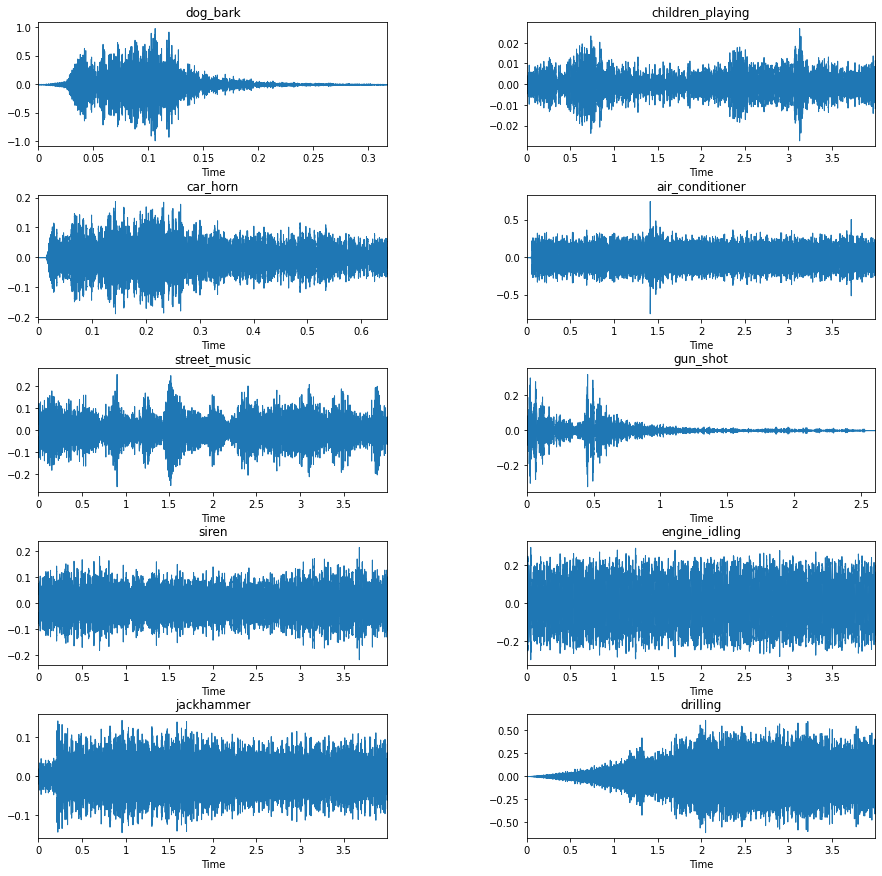

In [6]:
# create a list of the class labels
labels = list(df['class'].unique())

# let's grab a single audio file from each class
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = f'urbansound8k/fold{tmp["fold"][0]}/{tmp["slice_file_name"][0]}'
    files[labels[i]] = path

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr=sample_rate)
plt.savefig('class_examples.png')

# log graphic of waveforms to Comet
experiment.log_image('class_examples.png')

In [7]:
# log audio files to comet for debugging
for label in labels:
    fn = files[label]
    experiment.log_audio(fn, metadata={'name': label})

## Data Preprocessing

In [18]:
features = []
FULL_DATASET_PATH = 'urbansound8k'
WAVEFORM_MAX_LENGTH = 176400 # predetermined

def extract_features(file_name):
    try:
        _, data = wav.read(file_name)
        data = np.average(data, axis=1) # average two channels
        return data, True
    except:
        return None, False

# iterate through each sound file and extract features
for index, row in df.iterrows():
    file_name = os.path.join(os.path.abspath(FULL_DATASET_PATH), 'fold'+str(row['fold']) + '/', str(row['slice_file_name']))
    class_label = row['class']
    data, has_data = extract_features(file_name)
    if has_data:
        features.append([data, class_label])

# convert into a pandas dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])
featuresdf.head()

,feature,class_label
0,"[-149.0, -158.5, -151.0, -153.5, -160.0, -163....",dog_bark
1,"[117.0, 121.5, 113.0, 91.5, 79.0, 78.0, 74.0, ...",children_playing
2,"[-122.5, -108.5, -89.0, -71.5, -58.5, -47.5, -...",children_playing
3,"[8.5, 0.5, -7.0, -25.0, -45.5, -60.0, -73.0, -...",children_playing
4,"[53.5, 84.5, 135.5, 186.0, 208.0, 199.0, 177.5...",children_playing


In [ ]:
featuresdf.to_pickle('featuresdf.pkl')